<a href="https://colab.research.google.com/github/imroytran/Homework-DLS/blob/master/%5Bhw%5Dsemantic_segmentation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>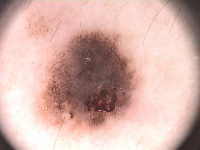</td><td>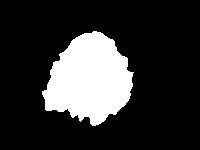</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-05-22 11:35:00--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-05-22 11:35:00--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucabbcb39b1dfaa606aba1e822b8.dl.dropboxusercontent.com/cd/0/inline/A4M7HIlHDaWh_z_-W89x23wPW-0BfuZ17N-l8r5lHiwJs1j6tWncrRBVQfhud-dvCqrIHV7tjc6b1PGUrQZJ4S00SmwEkqxlJrwNyz2hkomoIA/file# [following]
--2020-05-22 11:35:00--  https://ucabbcb39b1dfaa606aba1e822b8.dl.dropboxusercontent.com/cd/0/inline/A4M7HIlHDaWh_z_-W89x23wPW-0BfuZ17N-l8r5lHiwJs1j6tWncrRBVQfhud-dvCqrIHV7tjc6b1PGUrQZJ4S00SmwEkqxlJrwNyz2hkomoIA/file
Resolving 

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

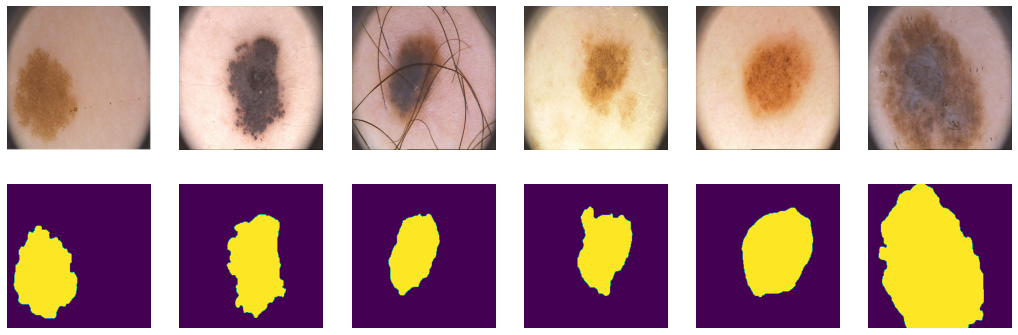

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

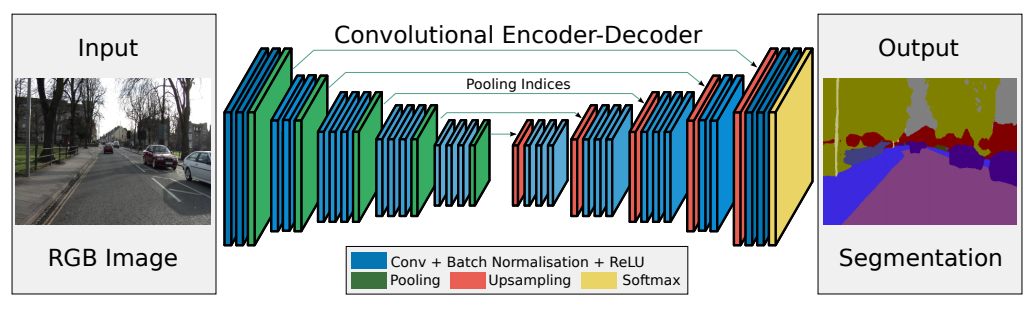

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv00 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.enc_conv01 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128 

        self.enc_conv10 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.enc_conv11 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64

        self.enc_conv20 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.enc_conv21 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.enc_conv22 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32

        self.enc_conv30 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.enc_conv31 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.enc_conv32 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv01 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv02 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv03 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.poolb = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.upsampleb = nn.MaxUnpool2d(2)
        self.bottleneck_conv30 = nn.Sequential(nn.ConvTranspose2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv20 = nn.Sequential(nn.ConvTranspose2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv10 = nn.Sequential(nn.ConvTranspose2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2) # 16 -> 32
        self.dec_conv00 = nn.Sequential(nn.ConvTranspose2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec_conv01 = nn.Sequential(nn.ConvTranspose2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec_conv02 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.upsample1 = nn.MaxUnpool2d(2) # 32 -> 64
        self.dec_conv10 = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec_conv11 = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec_conv12 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.upsample2 =  nn.MaxUnpool2d(2) # 64 -> 128
        self.dec_conv20 = nn.Sequential(nn.ConvTranspose2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.dec_conv21 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.upsample3 = nn.MaxUnpool2d(2)  # 128 -> 256
        self.dec_conv30 = nn.Sequential(nn.ConvTranspose2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.dec_conv31 = nn.Sequential(nn.ConvTranspose2d(32, 1, 3, 1, 1))

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(F.relu(self.enc_conv01(F.relu(self.enc_conv00(x)))))
        e1, ind1 = self.pool1(F.relu(self.enc_conv11(F.relu(self.enc_conv10(e0)))))
        e2, ind2 = self.pool2(F.relu(self.enc_conv22(F.relu(self.enc_conv21(F.relu(self.enc_conv20(e1)))))))
        e3, ind3 = self.pool3(F.relu(self.enc_conv32(F.relu(self.enc_conv31(F.relu(self.enc_conv30(e2)))))))

        # bottleneck
        b0, ind4 = self.poolb(F.relu(self.bottleneck_conv03(F.relu(self.bottleneck_conv02(F.relu(self.bottleneck_conv01(e3)))))))
        b1 = F.relu(self.bottleneck_conv10(F.relu(self.bottleneck_conv20(F.relu(self.bottleneck_conv30(self.upsampleb(b0, ind4)))))))

        # decoder
        d0 = F.relu(self.dec_conv02(F.relu(self.dec_conv01(F.relu(self.dec_conv00(self.upsample0(b1, ind3)))))))
        d1 = F.relu(self.dec_conv12(F.relu(self.dec_conv11(F.relu(self.dec_conv10(self.upsample1(d0, ind2)))))))
        d2 = F.relu(self.dec_conv21(F.relu(self.dec_conv20(self.upsample2(d1, ind1)))))
        d3 = self.dec_conv31(F.relu(self.dec_conv30(self.upsample3(d2, ind0))))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs += 0.5
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  #

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return (y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss = []
        val_scores = []
        test_scores = []
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)# forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        
        train_loss.append(avg_loss)
        
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = torch.sigmoid(model(X_val.to(device)).detach().cpu())# detach and put into cpu
        val_scores.append(score_model(model, iou_pytorch, data_val))
        test_scores.append(score_model(model, iou_pytorch, data_ts))
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        history.append((train_loss, val_scores, test_scores))
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        Y_label = Y_label.to(device)
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [0]:
torch.cuda.empty_cache()

In [0]:
#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [0]:
model = SegNet().to(device)

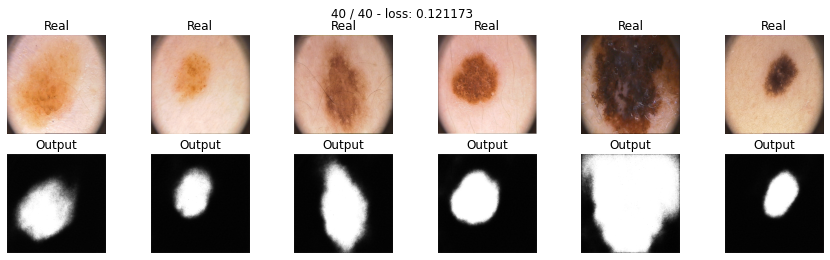

In [22]:
max_epochs = 40
optimizer  = optim.Adam(model.parameters(), lr=0.0001)
history_Seg_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [23]:
score_model(model, iou_pytorch, data_val)

0.721875011920929

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    num = (2*y_real*torch.sigmoid(y_pred)).sum()
    den =  (y_real + torch.sigmoid(y_pred)).sum()
    res = 1-num/den
    return res 

In [25]:
 '''def dice_loss(y_real, y_pred) :
    y_pred_s = torch.sigmoid(y_pred)
    y_pred_s = y_pred_s.view(-1)
    y_real = e_real.view(-1)
    smooth = 1.
    intersection = (y_pred_s*y_real).sum()
    dice = (2.*intersection + smooth)/(y_pred_s.sum() + y_real.sum() + smooth)
    return 1 - dice'''

'def dice_loss(y_real, y_pred) :\n   y_pred_s = torch.sigmoid(y_pred)\n   y_pred_s = y_pred_s.view(-1)\n   y_real = e_real.view(-1)\n   smooth = 1.\n   intersection = (y_pred_s*y_real).sum()\n   dice = (2.*intersection + smooth)/(y_pred_s.sum() + y_real.sum() + smooth)\n   return 1 - dice'

In [0]:
torch.cuda.empty_cache()

Проводим тестирование:

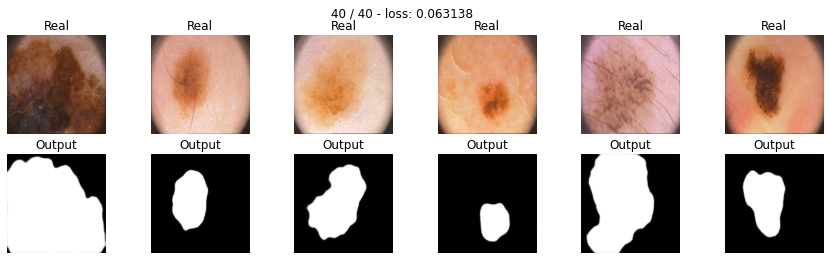

In [27]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_dice.parameters(), lr=0.0001)
history_Seg_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [28]:
score_model(model_dice, iou_pytorch, data_val)

0.7328125238418579

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [29]:
'''def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred).clamp(min=eps)
    focal_loss = - ((1-y_pred).pow(gamma)*y_real*(y_pred).log() + (1-y_real)*(1-y_pred).log()).mean()
    return focal_loss ''' #НЕ работает, дает loss nan


'def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):\n    y_pred = torch.sigmoid(y_pred).clamp(min=eps)\n    focal_loss = - ((1-y_pred).pow(gamma)*y_real*(y_pred).log() + (1-y_real)*(1-y_pred).log()).mean()\n    return focal_loss '

In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    inputs = y_pred.view(-1)
    targets = y_real.view(-1)
    alpha = 0.8
  
    BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
    return focal_loss

In [0]:
torch.cuda.empty_cache()

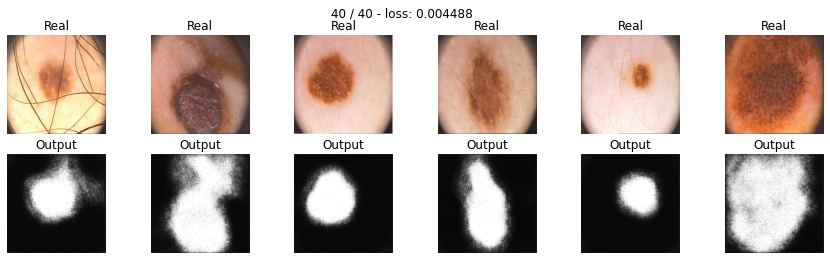

In [77]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters(), lr=0.0001)
history_Seg_focal = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [78]:
score_model(model_focal, iou_pytorch, data_val)

0.5437500178813934

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
def tversky_loss(y_real, y_pred):
  y_pred_sig = torch.sigmoid(y_pred)

  y_pred_sig = y_pred_sig.view(-1)
  y_real = y_real.view(-1)
  smooth = 1.
  alpha = 0.2
  beta = 1-alpha

  TP = (y_pred_sig * y_real).sum()    
  FP = ((1-y_real) * y_pred_sig).sum()
  FN = (y_real * (1-y_pred_sig)).sum()
       
  Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
  return 1-Tversky

In [0]:
torch.cuda.empty_cache()

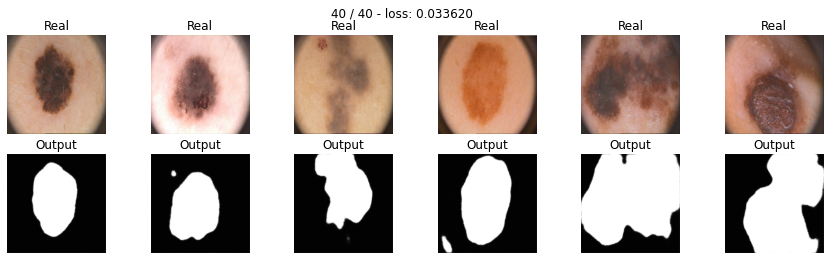

In [74]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_tversky.parameters(), lr=0.0001)
history_Seg_tversky = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [75]:
score_model(model_tversky, iou_pytorch, data_val)

0.6593750268220901

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

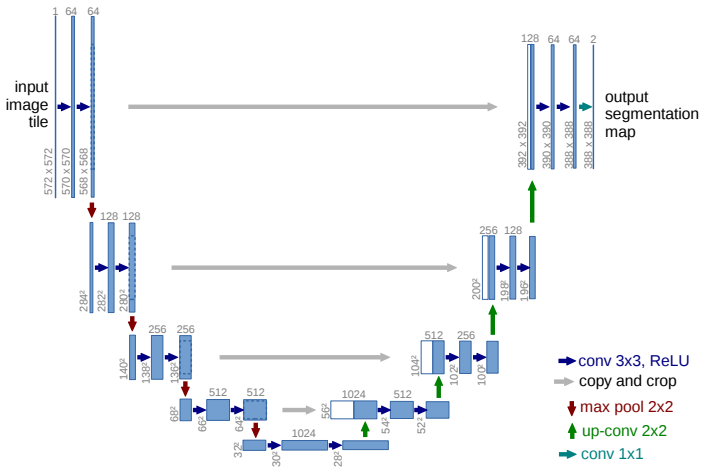




У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv00 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.enc_conv01 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv10 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.enc_conv11 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv20 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.enc_conv21 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv30 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.enc_conv31 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv00 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv01 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2) # 16 -> 32

        self.dec_conv00 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512))
        self.dec_conv01 = nn.Sequential(nn.Conv2d(512, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64

        self.dec_conv10 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec_conv11 = nn.Sequential(nn.Conv2d(256, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128

        self.dec_conv20 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec_conv21 = nn.Sequential(nn.Conv2d(128, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256

        self.dec_conv30 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.dec_conv31 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.output = nn.Sequential(nn.Conv2d(32, 1, 3, 1, 1))

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv01(F.relu(self.enc_conv00(x))))
        out = self.pool0(e0)
        e1 = F.relu(self.enc_conv11(F.relu(self.enc_conv10(self.pool0(e0)))))
        out = self.pool1(e1)        
        e2 = F.relu(self.enc_conv21(F.relu(self.enc_conv20(out))))
        out = self.pool2(e2)
        e3 = F.relu(self.enc_conv31(F.relu(self.enc_conv30(out))))
        out = self.pool3(e3)

        # bottleneck
        b = F.relu(self.bottleneck_conv01(F.relu(self.bottleneck_conv00(out))))
        out = self.upsample0(b)
        # decoder
        d0 = F.relu(self.dec_conv01(F.relu(self.dec_conv00(torch.cat((e3, out), 1)))))
        out = self.upsample1(d0)
        d1 = F.relu(self.dec_conv11(F.relu(self.dec_conv10(torch.cat((e2, out), 1)))))
        out = self.upsample2(d1)
        d2 = F.relu(self.dec_conv21(F.relu(self.dec_conv20(torch.cat((e1, out), 1)))))
        out = self.upsample3(d2)
        d3 = F.relu(self.dec_conv31(F.relu(self.dec_conv30(torch.cat((e0, out), 1))))) 
        output = self.output(d3) # no activation
        return output

In [0]:
unet_model_bce = UNet().to(device)

In [0]:
torch.cuda.empty_cache()

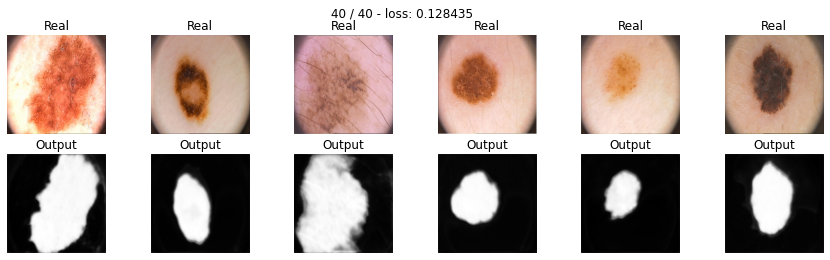

In [42]:
history_Unet1_bce = train(unet_model_bce, optim.Adam(unet_model_bce.parameters(), lr=0.0001), bce_loss, 40, data_tr, data_val)

In [43]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.7750000059604645

**Unet DICE loss function**

In [0]:
unet_model_dice = UNet().to(device)

In [0]:
torch.cuda.empty_cache()

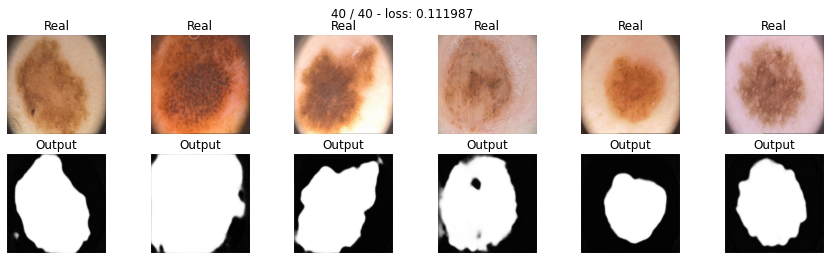

In [46]:
history_Unet1_dice = train(unet_model_dice, optim.Adam(unet_model_dice.parameters(), lr=0.0001), dice_loss, 40, data_tr, data_val)

In [47]:
score_model(unet_model_dice, iou_pytorch, data_val)

0.7765624970197678

**Unet Focal loss function**

In [0]:
unet_model_focal = UNet().to(device)

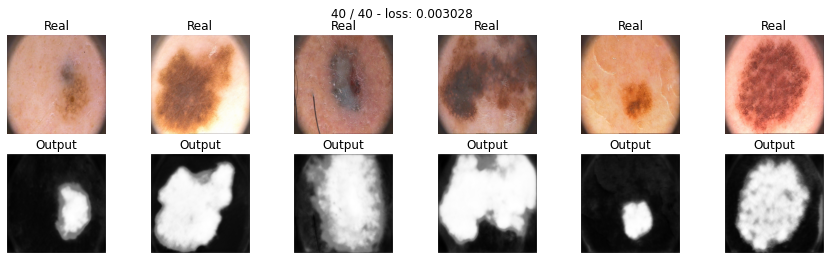

In [49]:
torch.cuda.empty_cache()
history_Unet1_focal = train(unet_model_focal, optim.Adam(unet_model_focal.parameters(), lr=0.0001), focal_loss, 40, data_tr, data_val)

In [50]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.7171875089406967

**Unet tversky loss function**


In [0]:
unet_model_tversky = UNet().to(device)

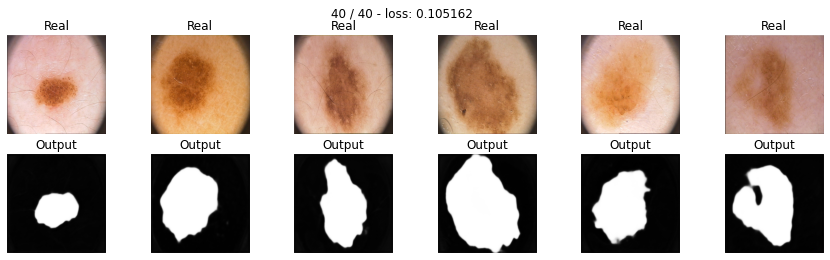

In [52]:
torch.cuda.empty_cache()
history_Unet1_tversky = train(unet_model_tversky, optim.Adam(unet_model_tversky.parameters(), lr=0.0001), tversky_loss, 40, data_tr, data_val)

In [53]:
score_model(unet_model_tversky, iou_pytorch, data_val)

0.7046875059604645

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv00 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.enc_conv01 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.pool0 = nn.Conv2d(32, 32, 3, stride=2, padding=1)  # 256 -> 128

        self.enc_conv10 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.enc_conv11 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.pool1 = nn.Conv2d(64, 64, 3, stride=2, padding=1) # 128 -> 64

        self.enc_conv20 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.enc_conv21 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.pool2 = nn.Conv2d(128, 128, 3, stride=2, padding=1) # 64 -> 32

        self.enc_conv30 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.enc_conv31 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        self.pool3 = nn.Conv2d(256, 256, 3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv00 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv01 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, 2, stride=2) # 16 -> 32

        self.dec_conv00 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512))
        self.dec_conv01 = nn.Sequential(nn.Conv2d(512, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.upsample1 = nn.ConvTranspose2d(128, 128, 2, stride=2) # 32 -> 64

        self.dec_conv10 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec_conv11 = nn.Sequential(nn.Conv2d(256, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride=2)  # 64 -> 128

        self.dec_conv20 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec_conv21 = nn.Sequential(nn.Conv2d(128, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.upsample3 = nn.ConvTranspose2d(32, 32, 2, stride=2) # 128 -> 256

        self.dec_conv30 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.dec_conv31 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.output = nn.Conv2d(32, 1, 3, 1, 1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv01(F.relu(self.enc_conv00(x))))
        out = self.pool0(e0)
        e1 = F.relu(self.enc_conv11(F.relu(self.enc_conv10(self.pool0(e0)))))
        out = self.pool1(e1)        
        e2 = F.relu(self.enc_conv21(F.relu(self.enc_conv20(out))))
        out = self.pool2(e2)
        e3 = F.relu(self.enc_conv31(F.relu(self.enc_conv30(out))))
        out = self.pool3(e3)

        # bottleneck
        b = F.relu(self.bottleneck_conv01(F.relu(self.bottleneck_conv00(out))))
        out = self.upsample0(b)
        # decoder
        d0 = F.relu(self.dec_conv01(F.relu(self.dec_conv00(torch.cat((e3, out), 1)))))
        out = self.upsample1(d0)
        d1 = F.relu(self.dec_conv11(F.relu(self.dec_conv10(torch.cat((e2, out), 1)))))
        out = self.upsample2(d1)
        d2 = F.relu(self.dec_conv21(F.relu(self.dec_conv20(torch.cat((e1, out), 1)))))
        out = self.upsample3(d2)
        d3 = F.relu(self.dec_conv31(F.relu(self.dec_conv30(torch.cat((e0, out), 1))))) 
        output = self.output(d3) # no activation
        return output

In [0]:
unet2_model_bce = UNet2().to(device)

In [0]:
torch.cuda.empty_cache()

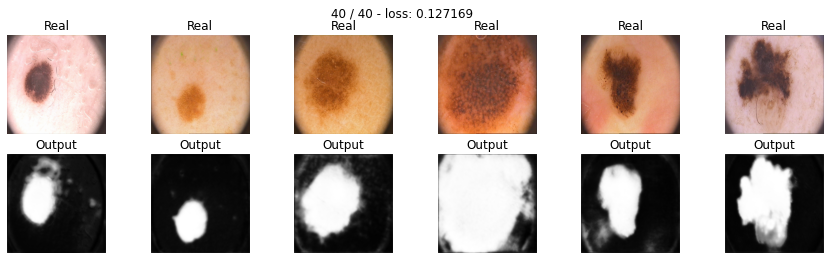

In [57]:
history_Unet2_bce = train(unet2_model_bce, optim.Adam(unet2_model_bce.parameters(), lr=0.0001), bce_loss, 40, data_tr, data_val)

In [58]:
score_model(unet2_model_bce, iou_pytorch, data_val)

0.7312500029802322

**Unet2 with DICE loss function**

In [0]:
unet2_model_dice = UNet2().to(device)

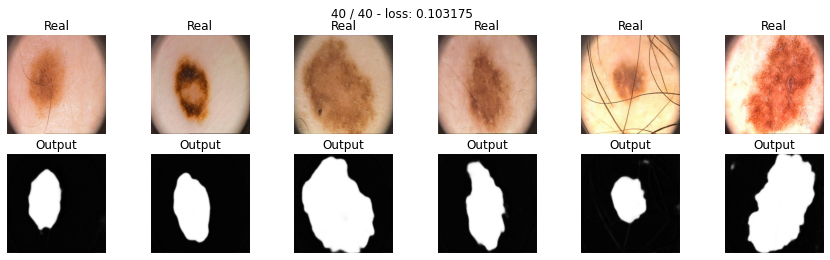

In [60]:
torch.cuda.empty_cache()
history_Unet2_dice = train(unet2_model_dice, optim.Adam(unet2_model_dice.parameters(), lr=0.0001), dice_loss, 40, data_tr, data_val)

In [61]:
score_model(unet2_model_dice, iou_pytorch, data_val)

0.7125000059604645

**Unet2 with focal loss function**

In [0]:
unet2_model_focal = UNet2().to(device)

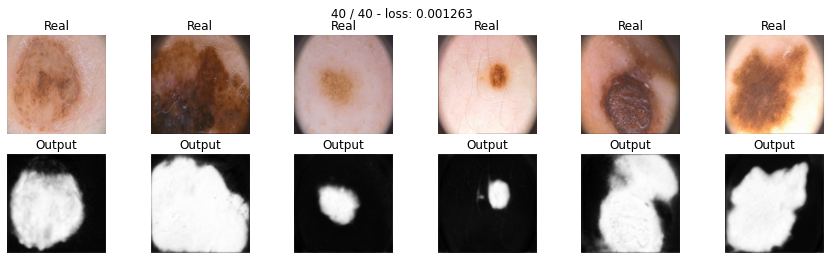

In [63]:
torch.cuda.empty_cache()
history_Unet2_focal = train(unet2_model_focal, optim.Adam(unet2_model_focal.parameters(), lr=0.0001), focal_loss, 40, data_tr, data_val)

In [64]:
score_model(unet2_model_focal, iou_pytorch, data_val)

0.7187500149011612

**Unet2 with tversky loss function**

In [0]:
unet2_model_tversky = UNet2().to(device)

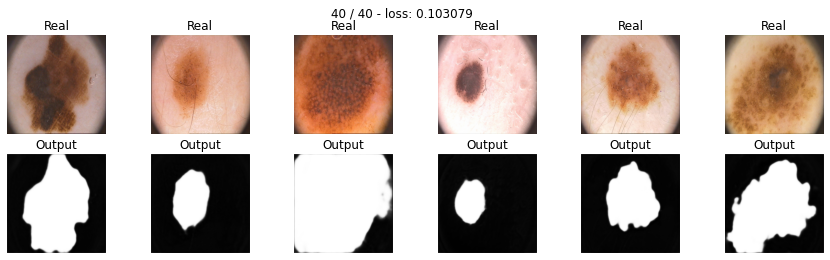

In [66]:
torch.cuda.empty_cache()
history_Unet2_tversky = train(unet2_model_tversky, optim.Adam(unet2_model_tversky.parameters(), lr=0.0001), tversky_loss, 40, data_tr, data_val)

In [67]:
score_model(unet2_model_tversky, iou_pytorch, data_val)

0.7656250149011612

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [68]:
'''class DilatedSegNet(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv00 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32))
        self.enc_conv01 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.pool0 = nn.Conv2d(32, 32, 3, dilation=2)  # 256 -> 128

        self.enc_conv10 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.enc_conv11 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.pool1 = nn.Conv2d(64, 64, 3, dilation=2) # 128 -> 64

        self.enc_conv20 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.enc_conv21 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.pool2 = nn.Conv2d(128, 128, 3, dilation=2) # 64 -> 32

        self.enc_conv30 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.enc_conv31 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        self.pool3 = nn.Conv2d(256, 256, 3, dilation=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv00 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.bottleneck_conv01 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, 2, stride=2) # 16 -> 32

        self.dec_conv00 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512))
        self.dec_conv01 = nn.Sequential(nn.Conv2d(512, 128, 3, 1, 1), nn.BatchNorm2d(128))

        self.upsample1 = nn.ConvTranspose2d(128, 128, 2, stride=2) # 32 -> 64

        self.dec_conv10 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256))
        self.dec_conv11 = nn.Sequential(nn.Conv2d(256, 64, 3, 1, 1), nn.BatchNorm2d(64))

        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride=2)  # 64 -> 128

        self.dec_conv20 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))
        self.dec_conv21 = nn.Sequential(nn.Conv2d(128, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.upsample3 = nn.ConvTranspose2d(32, 32, 2, stride=2) # 128 -> 256

        self.dec_conv30 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))
        self.dec_conv31 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32))

        self.output = nn.Conv2d(32, 1, 3, 1, 1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv01(F.relu(self.enc_conv00(x))))
        out = self.pool0(e0)
        e1 = F.relu(self.enc_conv11(F.relu(self.enc_conv10(self.pool0(e0)))))
        out = self.pool1(e1)        
        e2 = F.relu(self.enc_conv21(F.relu(self.enc_conv20(out))))
        out = self.pool2(e2)
        e3 = F.relu(self.enc_conv31(F.relu(self.enc_conv30(out))))
        out = self.pool3(e3)

        # bottleneck
        b = F.relu(self.bottleneck_conv01(F.relu(self.bottleneck_conv00(out))))
        out = self.upsample0(b)
        # decoder
        d0 = F.relu(self.dec_conv01(F.relu(self.dec_conv00(torch.cat((e3, out), 1)))))
        out = self.upsample1(d0)
        d1 = F.relu(self.dec_conv11(F.relu(self.dec_conv10(torch.cat((e2, out), 1)))))
        out = self.upsample2(d1)
        d2 = F.relu(self.dec_conv21(F.relu(self.dec_conv20(torch.cat((e1, out), 1)))))
        out = self.upsample3(d2)
        d3 = F.relu(self.dec_conv31(F.relu(self.dec_conv30(torch.cat((e0, out), 1))))) 
        output = self.output(d3) # no activation
        return output'''

'class DilatedSegNet(nn.Module):\n\n    def __init__(self):\n        super().__init__()\n\n        # encoder (downsampling)\n        self.enc_conv00 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32))\n        self.enc_conv01 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.BatchNorm2d(32))\n\n        self.pool0 = nn.Conv2d(32, 32, 3, dilation=2)  # 256 -> 128\n\n        self.enc_conv10 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64))\n        self.enc_conv11 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64))\n\n        self.pool1 = nn.Conv2d(64, 64, 3, dilation=2) # 128 -> 64\n\n        self.enc_conv20 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128))\n        self.enc_conv21 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128))\n\n        self.pool2 = nn.Conv2d(128, 128, 3, dilation=2) # 64 -> 32\n\n        self.enc_conv30 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256))\n        self.enc_conv31 = nn.

In [0]:
#model = DilatedSegNet().to(device)

In [0]:
#train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



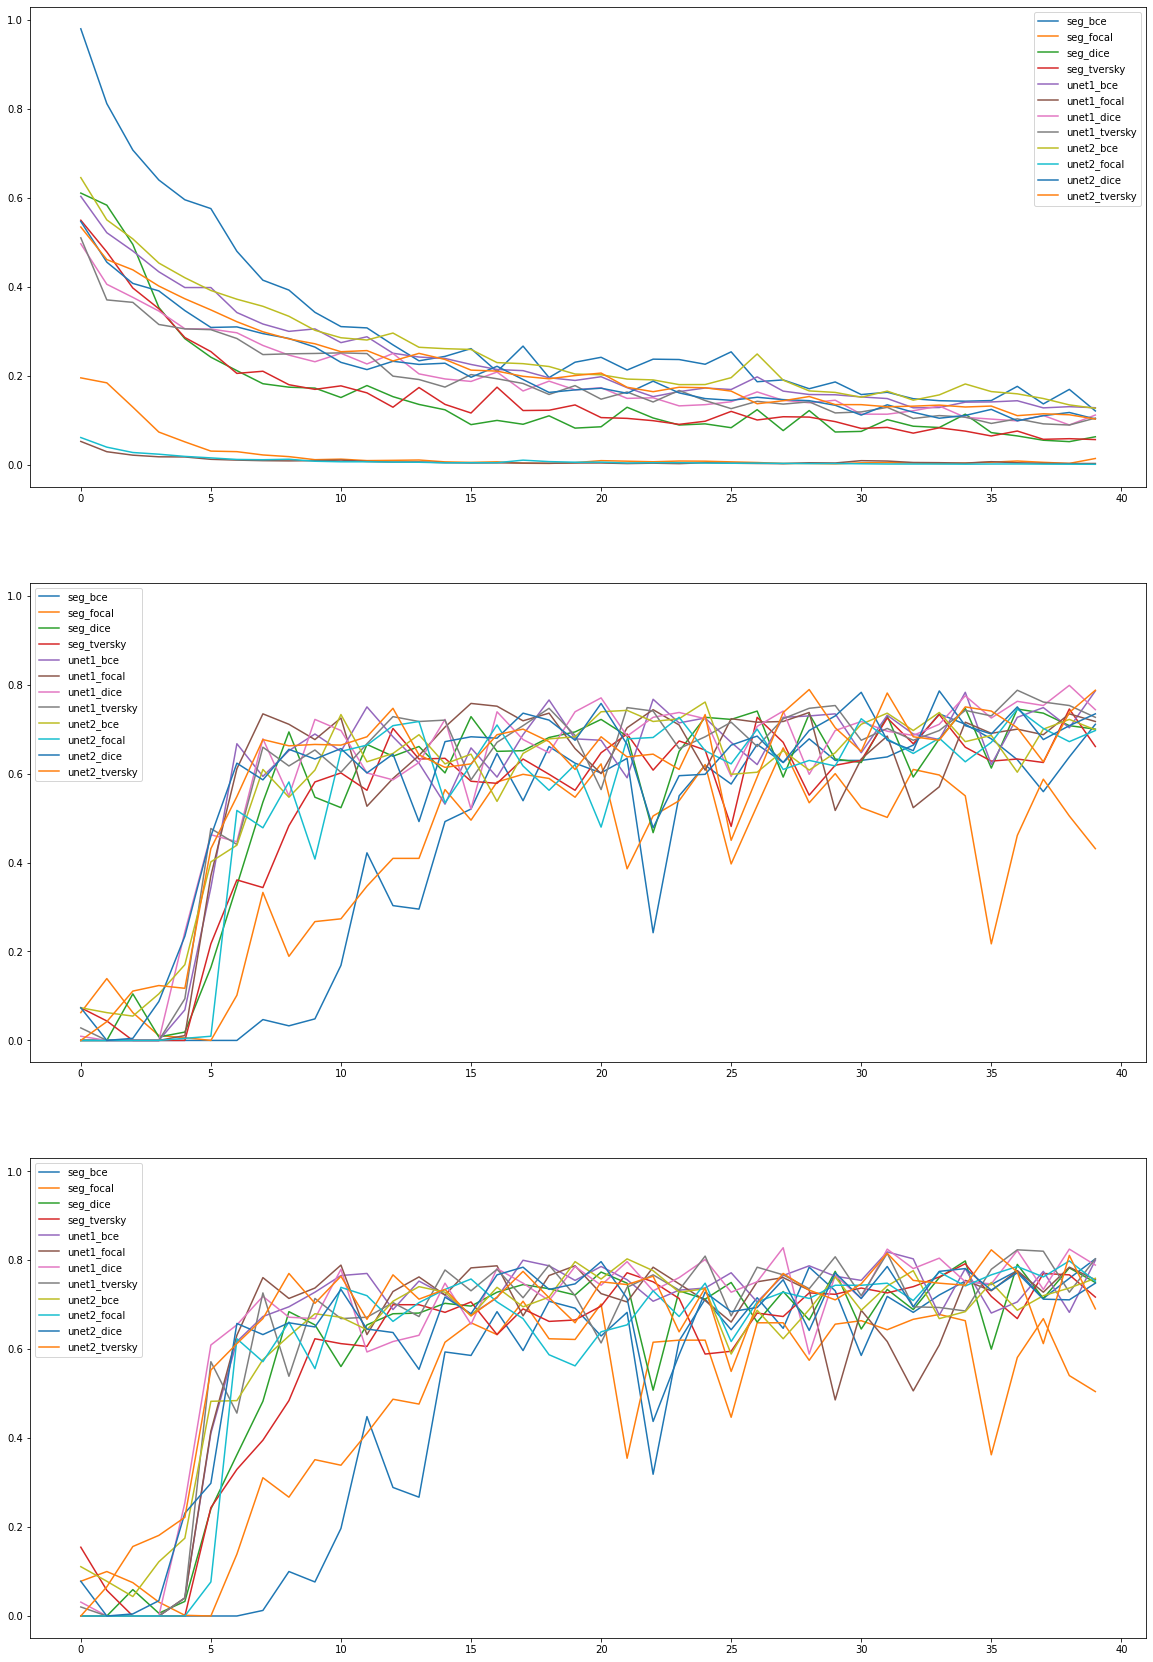

In [72]:
dict_hist = {}
hist_names = ['seg_bce', 'seg_focal', 'seg_dice', 'seg_tversky', 
              'unet1_bce', 'unet1_focal', 'unet1_dice', 'unet1_tversky',
              'unet2_bce', 'unet2_focal', 'unet2_dice', 'unet2_tversky']
for ind, hist in enumerate([history_Seg_bce, history_Seg_focal, history_Seg_dice, history_Seg_tversky,
                            history_Unet1_bce, history_Unet1_focal, history_Unet1_dice, history_Unet1_tversky,
                            history_Unet2_bce, history_Unet2_focal, history_Unet2_dice, history_Unet2_tversky]):
  dict_hist[hist_names[ind]] = hist

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20, 30), sharey=True)

for name, hist in dict_hist.items():
    train_loss, val_scores, test_scores = zip(*hist)
    ax1.plot(train_loss, label=name)
    ax2.plot(val_scores, label=name)
    ax3.plot(test_scores, label=name)
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')